In [ ]:
!nvidia-smi

Fri Jan 20 01:20:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [ ]:
import tensorflow_datasets as tfds
datasets_list = tfds.list_builders() 
print("food101" in datasets_list) 

True


In [ ]:
(train_data, test_data), ds_info = tfds.load(name="food101", 
                                             split=["train", "validation"], 
                                             shuffle_files=True, 
                                             as_supervised=True, 
                                             with_info=True) 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteRYNDVS/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteRYNDVS/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [ ]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [ ]:
def tensorboard_callback(dir_name, experiment_name):

  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 

In [ ]:
class_names = ds_info.features["label"].names

In [ ]:
len(class_names)

101

In [ ]:
from tensorflow.python.ops import losses
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers

input_shape = (224,224,3)

mixed_precision.set_global_policy(policy="mixed_float16")

base_model = tf.keras.applications.EfficientNetV2M(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape= input_shape, name = 'input_layer')
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D(name = 'pooling_layer')(x)
x = layers.Dense(units = len(class_names))(x)

outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 

model = tf.keras.Model(inputs, outputs)

model.compile ( loss = tf.keras.losses.sparse_categorical_crossentropy,
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy']
               )


214201816/214201816 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-m (Functiona  (None, None, None, 1280)  53150388 
 l)                                                              
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense_5 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                           

In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=5,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "EfficentnetV2Medium_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/EfficentnetV2Medium_101_classes_all_data_feature_extract/20230120-015139
Epoch 1/5
2368/2368 [==============================] - 275s 115ms/step - loss: 1.9698 - accuracy: 0.5200 - val_loss: 1.3895 - val_accuracy: 0.6380
Epoch 2/5
2368/2368 [==============================] - 272s 114ms/step - loss: 1.4586 - accuracy: 0.6262 - val_loss: 1.2648 - val_accuracy: 0.6711
Epoch 3/5
2368/2368 [==============================] - 271s 113ms/step - loss: 1.3129 - accuracy: 0.6605 - val_loss: 1.2032 - val_accuracy: 0.6788
Epoch 4/5
2368/2368 [==============================] - 269s 113ms/step - loss: 1.2213 - accuracy: 0.6821 - val_loss: 1.1627 - val_accuracy: 0.6923
Epoch 5/5
2368/2368 [==============================] - 269s 113ms/step - loss: 1.1555 - accuracy: 0.6978 - val_loss: 1.1363 - val_accuracy: 0.7076


In [ ]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 86s 108ms/step - loss: 1.1250 - accuracy: 0.7024


[1.125048041343689, 0.7024158239364624]

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

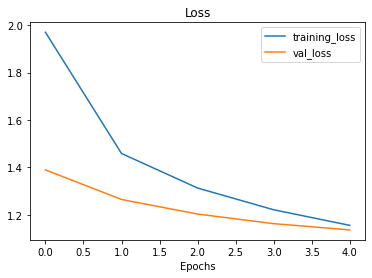

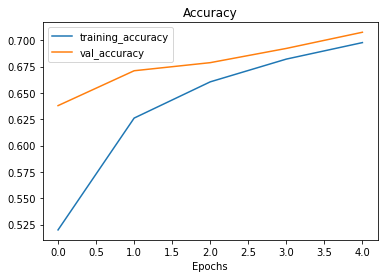

In [ ]:
plot_loss_curves(history_101_food_classes_feature_extract)

In [ ]:
for layer in model.layers:
    layer.trainable = True

In [ ]:
for layer in model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_5 True float32 <Policy "float32">
rescaling_4 True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block1a_project_activation True float32 <Policy "mixed_float16">
block1a_add True float32 <Policy "mixed_float16">
block1b_project_conv True float32 <Policy "mixed_float16">
block1b_project_bn True float32 <Policy "mixed_float16">
block1b_project_activation True float32 <Policy "mixed_float16">
block1b_drop True float32 <Policy "mixed_float16">
block1b_add True float32 <Policy "mixed_float16">
block1c_project_conv True float32 <Policy "mixed_float16">
block1c_project_bn True float32 <Policy "mixed_float16">
block1c_project_activation True float32 <Policy "mixed_float16">
block1c_drop True float32 <Policy "mixed_float16">
block1c_add True 

In [ ]:
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, 
                                                 patience=2,
                                                 verbose=1, 
                                                 min_lr=1e-7)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=2)

In [ ]:
Fine_tune_epoch = 5
model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

history_101_food_fine_tune = model.fit(train_data,
                                                        epochs=10, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        initial_epoch=history_101_food_classes_feature_extract.epoch[-1],
                                                        validation_steps=int(0.15 * len(test_data)),
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientv2Medium_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, 
                                                                   early_stopping, 
                                                                   reduce_lr]) 

Saving TensorBoard log files to: training_logs/efficientv2Medium_101_classes_all_data_fine_tuning/20230120-022420
Epoch 5/10
2368/2368 [==============================] - ETA: 0s - loss: 0.9961 - accuracy: 0.7333

2368/2368 [==============================] - 1087s 435ms/step - loss: 0.9961 - accuracy: 0.7333 - val_loss: 0.6749 - val_accuracy: 0.8157 - lr: 1.0000e-04
Epoch 6/10
2368/2368 [==============================] - ETA: 0s - loss: 0.4521 - accuracy: 0.8694

2368/2368 [==============================] - 1029s 434ms/step - loss: 0.4521 - accuracy: 0.8694 - val_loss: 0.6305 - val_accuracy: 0.8215 - lr: 1.0000e-04
Epoch 7/10
2368/2368 [==============================] - 875s 369ms/step - loss: 0.2203 - accuracy: 0.9312 - val_loss: 0.6893 - val_accuracy: 0.8244 - lr: 1.0000e-04
Epoch 8/10
2368/2368 [==============================] - ETA: 0s - loss: 0.1559 - accuracy: 0.9495
Epoch 8: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 884s 372ms/step - loss: 0.1559 - accuracy: 0.9495 - val_loss: 0.7408 - val_accuracy: 0.8289 - lr: 1.0000e-04


In [ ]:
results_fine_tune_model = model.evaluate(test_data)
results_fine_tune_model

790/790 [==============================] - 80s 101ms/step - loss: 0.7446 - accuracy: 0.8245


[0.7445856332778931, 0.8245148658752441]

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):

    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

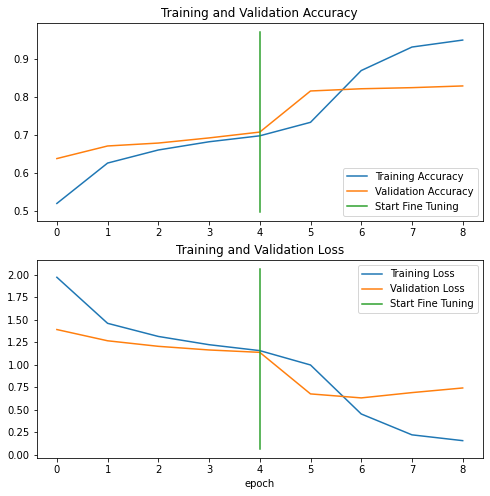

In [ ]:
compare_historys(original_history=history_101_food_classes_feature_extract,
                 new_history=history_101_food_fine_tune,
                 initial_epochs=5)